In [144]:
from dataset.msc_sessions import MSC_Session
from dataset.msc_speechact import MSC_SpeechAct
from models.speechact_clf import SpeechactClassifier
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import json
import itertools
import random
from collections import Counter

In [4]:
configs_options = {
    "speaker_prefixes": [None, ["<other>", "<self>"]],
}
basedir = "/Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/"
checkpoint_dir = "/Users/FrankVerhoef/Programming/PEX/checkpoints/"
subsets = {
    # 1: ['train', 'valid', 'test'],
    # 2: ['train', 'valid', 'test'],
    3: ['train', 'valid', 'test'],
    # 4: ['train', 'valid', 'test'],
    # 5: ['valid', 'test']
}

In [5]:
configs = {
    "default": {
        "speaker_prefixes": ["<other>", "<self>"],
        "sessionbreak_token": "<sessionbreak>",
        "speechact_classifier": None
    },
    "speechacts": {
        "speaker_prefixes": ["<other>", "<self>"],
        "sessionbreak_token": "<sessionbreak>",
        "speechact_classifier": SpeechactClassifier(checkpoint_dir=checkpoint_dir, modelname="trained_speechact_bert")
    }
}

variants = {
    "no_persona_no_hist": {"include_persona": False, "include_history": False},
    # "persona_no_hist": {"include_persona": True, "include_history": False},
    # "persona_and_hist": {"include_persona": True, "include_history": True},
}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
MSC_Session.set(**configs['speechacts'])

In [7]:
max_samples = 100
msc_sessions = {}
for session in subsets.keys():
    if session == 1:
        version = ['both', 'revised']
        session = '-'.join(['1'] + version)
    msc_sessions[int(str(session)[0])] = {}
    for option_name in variants.keys():
        msc_sessions[int(str(session)[0])][option_name] = {
            subset: MSC_Session(basedir=basedir, session=session, subset=subset, max_samples=max_samples, **variants[option_name]) 
            for subset in subsets[int(str(session)[0])]
        }



2023-07-20 15:53:30,854 INFO     | Read 4000 dialogues from MSC session 3 for train dataset
2023-07-20 15:53:30,875 INFO     | Read 500 dialogues from MSC session 3 for valid dataset
2023-07-20 15:53:30,895 INFO     | Read 501 dialogues from MSC session 3 for test dataset


In [ ]:
m = {
    session: {
        option_name: {subset: msc_sessions[session][option_name][subset].measurements() for subset in subsets[session]}
        for option_name in variants.keys()
    }
    for session in subsets.keys()
}

In [8]:
import json
with open('speechact_test_s3_100.json', 'r') as f:
    # f.write(json.dumps(m))
    m = {3: json.loads(f.read())['3']}

## Show a few examples

In [ ]:
for i in range(10):
    print(msc_sessions[1]['no_persona_no_hist']['train'][i])

In [ ]:
for i in range(10):
    print(msc_sessions[2]['persona_and_hist']['train'][i])

In [ ]:
for i in range(10):
    print(msc_sessions[4]['persona_and_hist']['valid'][i])

## Speechacts

In [ ]:
sessions = [3]
variant = "no_persona_no_hist"
subset = 'train'
shuffled_dialogues = [
    (msc_sessions[3][variant]['train'].indices[i], msc_sessions[3][variant]['train'].history[i])
    for i in np.random.permutation(len(msc_sessions[3][variant]['train']))]
ref_stats, ref_selfchats_results = MSC_Session.calc_speechact_stats(shuffled_dialogues)
ref_stats

In [15]:
filename = '/Users/FrankVerhoef/Programming/PEX/notebooks/speechact_test_s3_100.json'
with open (filename, 'r') as f:
    m = {3: json.loads(f.read())['3']}

In [16]:
print(m.keys())
print(m[3].keys())
print(m[3]['no_persona_no_hist'].keys())
Counter(m[3][variant][subset]['speechacts'])

dict_keys([3])
dict_keys(['no_persona_no_hist'])
dict_keys(['train', 'valid', 'test'])


Counter({'A': 308, 'S': 720, 'E': 886, 'Q': 589, 'R': 276, 'P': 126})

In [163]:
from scipy.stats import chi2_contingency, wasserstein_distance

def chi_squared(observed, floor=0):
    # remove rows with 0 sum
    filtered = observed[observed.sum(axis=1) > max(floor, 0)]
    # print(f"Filtered: {1 - np.sum(filtered) / np.sum(observed):.2%}")
    return chi2_contingency(filtered)

def normalize(counter):
    total = sum(counter.values())
    normalized = {k: v / total for k, v in counter.items()}
    return normalized

def speechact_sim(speechacts_1, speechacts_2):
    """
    Calculates a similarity score between two dialogues based on the probability of the speechacts in each item.
    Based on averag of squared difference between probabilities of speechacts
    """
    dist_1 = normalize(speechacts_1)
    dist_2 = normalize(speechacts_2)
    diff = np.array([dist_1.get(speechact, 0) - dist_2.get(speechact, 0) for speechact in MSC_SpeechAct.classes.keys()])
    sim = sum(diff * diff) / len(speechact_keys)
    return sim

observations = np.array([
    [13, 15],
    [30, 13],
    [44, 65]
])

print(chi_squared(observations))


Chi2ContingencyResult(statistic=10.721571792595633, pvalue=0.004697213134214071, dof=2, expected_freq=array([[13.53333333, 14.46666667],
       [20.78333333, 22.21666667],
       [52.68333333, 56.31666667]]))


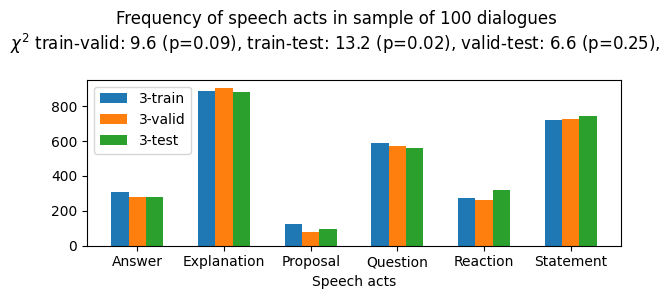

In [159]:
# Chi-squared test applied to frequency of speechacts

sorted_acts = sorted(sum([Counter(m[s][variant][subset]['speechacts']) for s in sessions for subset in ['train', 'valid', 'test']], Counter()).keys())
x_acts = np.arange(len(sorted_acts))

data = np.array([
    [m[3][variant][subset]["speechacts"].get(k, 0) for k in sorted_acts]
    for subset in ['train', 'valid', 'test']
])

chi_tt = chi_squared(data[np.array([0,1])].T, floor=0)
chi_tv = chi_squared(data[np.array([0,2])].T, floor=0)
chi_vt = chi_squared(data[np.array([1,2])].T, floor=0)

fig, ax = plt.subplots(figsize=(6,3))
for i, (s, subset) in enumerate(itertools.product(sessions, ['train', 'valid', 'test'])):
    subset_m = m[s][variant][subset]
    offset = 0.2 * i - 0.2
    ax.bar(x_acts + offset, height=data[i], width=0.2, label=f"{s}-{subset}")
    # ax.bar(x_acts + offset, height=[subset_m["speechacts"].get(k, 0) for k in sorted_acts], width=0.2, label=f"{s}-{subset}")

ax.set_xticks(x_acts)
ax.set_xticklabels([MSC_SpeechAct.classes[c] for c in sorted_acts], rotation=0)
ax.set_xlabel("Speech acts")
ax.legend()

fig.suptitle(f"Frequency of speech acts in sample of 100 dialogues\n$\chi^2$ "
    f"train-valid: {chi_tv.statistic:.1f} (p={chi_tv.pvalue:.2f}), "
    f"train-test: {chi_tt.statistic:.1f} (p={chi_tt.pvalue:.2f}), "
    f"valid-test: {chi_vt.statistic:.1f} (p={chi_vt.pvalue:.2f}), "
)
fig.tight_layout()


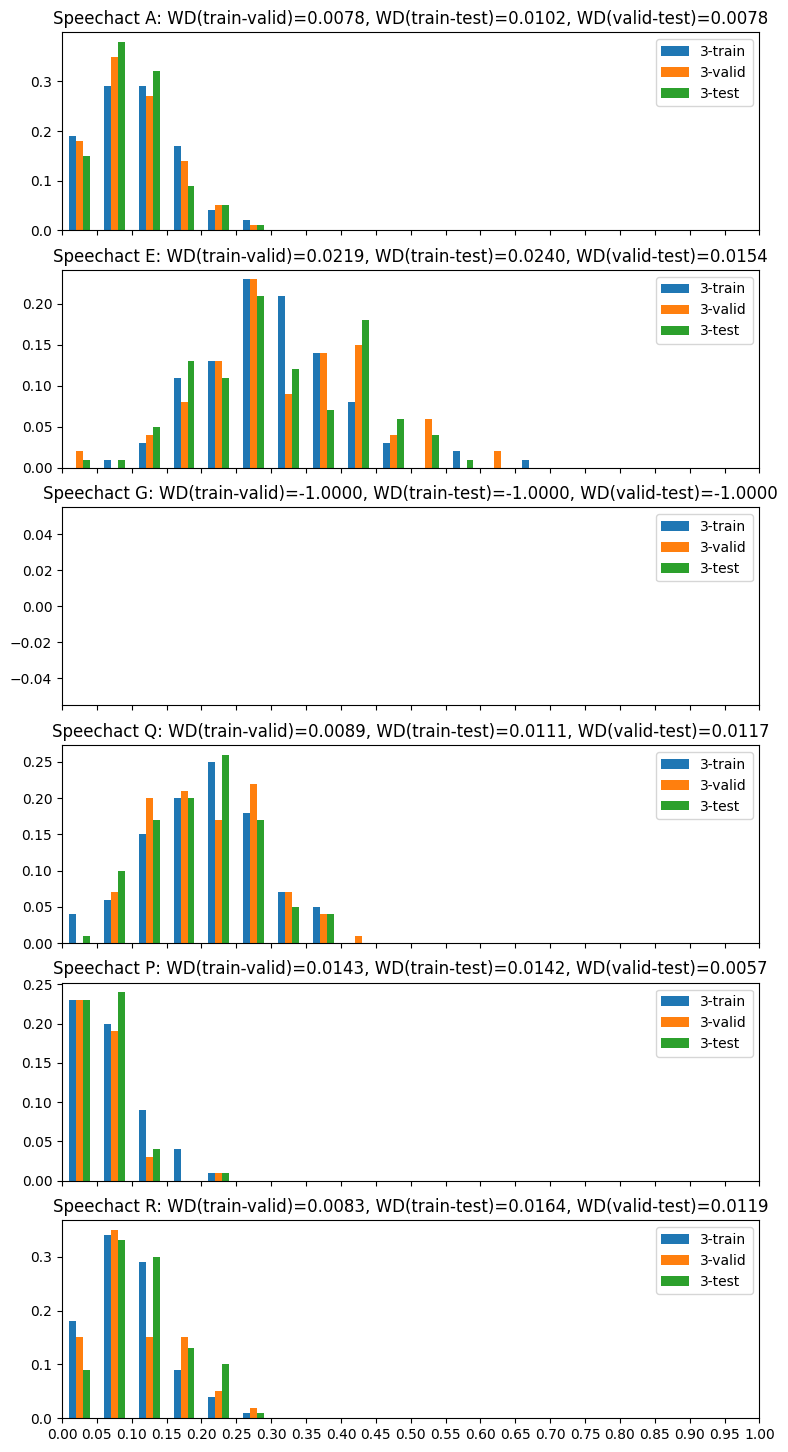

In [160]:
# Wasserstein Distance calculated between probabilities of speechacts per dialogue

for subset in ['train', 'valid', 'test']:
    all_measurements = m[3]['no_persona_no_hist'][subset]['allitem_measurements']
    for measurements in all_measurements:
        measurements['speechacts_normalized'] = normalize(measurements['speechacts'])

speechact_keys = MSC_SpeechAct.classes.keys()

fig, axs = plt.subplots(nrows=len(speechacts), figsize=(9,3 * len(speechacts)), sharex=True)
num_bins = 20
bins = np.linspace(0, 1, num_bins+1)
x = np.arange(num_bins)

for speechact, ax in zip(speechact_keys, axs):
    data = {
        subset: np.array([
            measurements['speechacts_normalized'][speechact] 
            for measurements in m[3]['no_persona_no_hist'][subset]['allitem_measurements']
            if speechact in measurements['speechacts_normalized'].keys()
            ])
        for subset in ['train', 'valid', 'test']
    }
    for i, subset in enumerate(['train', 'valid', 'test']):
        hist = np.histogram(data[subset], bins=bins)
        # print(hist)
        offset = 0.2 * i + 0.3
        ax.bar(x + offset, height=hist[0]/100, width=0.2, label=f"{3}-{subset}")


    wd_tv = wasserstein_distance(data['train'], data['valid']) if len(data['train']) > 0 else -1
    wd_tt = wasserstein_distance(data['train'], data['test'])if len(data['train']) > 0 else -1
    wd_vt = wasserstein_distance(data['valid'], data['test'])if len(data['valid']) > 0 else -1

    ax.set_title(f"Speechact {speechact}: WD(train-valid)={wd_tv:.4f}, WD(train-test)={wd_tt:.4f}, WD(valid-test)={wd_vt:.4f}")
    ax.legend()
    ax.set_xlim(0, num_bins)
    ax.set_xticks(np.arange(num_bins + 1))
    ax.set_xticklabels([f"{b:.2f}" for b in bins])



In [161]:
def speechact_sim(speechacts_1, speechacts_2):

    dist_1 = normalize(speechacts_1)
    dist_2 = normalize(speechacts_2)
    diff = np.array([dist_1.get(speechact, 0) - dist_2.get(speechact, 0) for speechact in MSC_SpeechAct.classes.keys()])
    sim = sum(diff * diff) / len(speechact_keys)

    return sim


A ['train', 'valid']
(array([77, 21,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0]), array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]))
A ['train', 'test']
(array([81, 16,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0]), array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]))
A ['valid', 'test']
(array([66, 27,  5,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0]), array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]))
E ['train', 'valid']
(array([80, 18,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0]), array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 

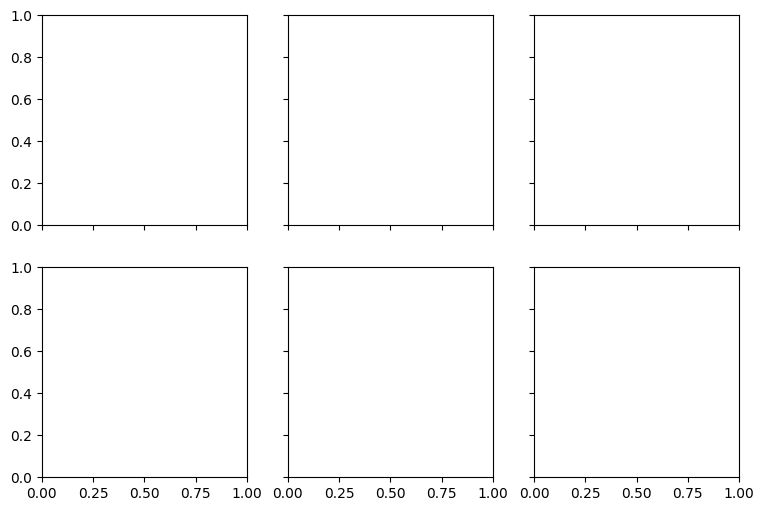

In [162]:
# Test to visualize similarity between dialogues on item level
# (but this does not really make sense)

for subset in ['train', 'valid', 'test']:
    all_measurements = m[3]['no_persona_no_hist'][subset]['allitem_measurements']
    for measurements in all_measurements:
        measurements['speechacts_normalized'] = normalize(measurements['speechacts'])

speechact_keys = ['A', 'E'] #, 'P', 'Q', 'R', 'S']
comparisons = [['train', 'valid'], ['train', 'test'], ['valid', 'test']]

fig, axs = plt.subplots(nrows=len(speechact_keys), ncols=len(comparisons), figsize=(3 * len(comparisons),3 * len(speechact_keys)), sharex=True, sharey=True)

num_bins = 20
num_samples = 100
bins = np.linspace(0, 1, num_bins+1)
x = np.arange(num_bins)

for (speechact, comparison), ax in zip(itertools.product(speechact_keys, comparisons), axs.flatten()):

    # Take random samples of two sets and calculate similarity
    print(speechact, comparison)
    list_1 = [item_m['speechacts'] for item_m in m[3]['no_persona_no_hist'][comparison[0]]['allitem_measurements']]
    list_2 = [item_m['speechacts'] for item_m in m[3]['no_persona_no_hist'][comparison[1]]['allitem_measurements']]
    data = np.array([
        speechact_sim(item_1, item_2)
        for item_1, item_2 in zip(random.choices(list_1, k=num_samples), random.choices(list_2, k=num_samples))
    ])
    # print(data)
    hist = np.histogram(data, bins=bins)
    print(hist)



## Measurements overview with Pandas Dataframe

In [ ]:
# Collect all item measurements in a dataframe

df_colums = list(m[1]["no_persona_no_hist"]['train']["allitem_measurements"][0].keys())
df = pd.DataFrame(columns=df_colums).astype('int16')

for session in subsets.keys():
    for variant in variants.keys():
        for subset in subsets[session]:
            subset_df = pd.DataFrame.from_dict(m[session][variant][subset]["allitem_measurements"])

            subset_df["session"] = int(session)
            subset_df["variant"] = variant
            subset_df["subset"] = subset
        
            df = pd.concat([df, subset_df])

df["session"] = df["session"].astype('int')
df.describe()


In [ ]:
df.head()

In [ ]:
# Overview of statistics, by session and subset

df.groupby(["session", "variant", "subset"]).agg({'turn_id': ['count'], 'inputwords': ['mean', 'std'], 'inputsentences': ['mean', 'std'], 'labelwords': ['mean', 'std'], })

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=5, figsize=(12, 12))

def plot_hist_bar(ax, values, session, title, bins, range):

    if session==5:
        label = '-' # add empty label
        vals = [-1]  # plot a bar, outside the range
        ax.hist(vals, bins=bins, range=range, alpha=0.5, label=label, density=True)
    for subset, vals in zip(subsets[session], values): 
        label = f"{subset}: " + r"$\mu$" + f"={vals.mean():.0f}, " + r"$\sigma$" + f"={vals.std():.0f}"
        ax.hist(vals, bins=bins, range=range, alpha=0.5, label=label, density=True)
    ax.legend()
    ax.set_title(title)
    return ax

for j, variant in enumerate(variants.keys()):
    for i, session in enumerate(subsets.keys()):
        m_input = []
        for subset in subsets[session]:
            selection = selection = (df["session"] == session) & (df["variant"] == variant) & (df["subset"] == subset)
            m_input.append(df[selection]['inputwords'].values)
        bar_axes = plot_hist_bar(ax[i][j], m_input, session, title=f"Session_{session}, {variant}\nn={len(m_input[0])}", bins=40, range=(0,2000))

fig.suptitle(f"Distribution of number of inputwords (persona sentences, history, current dialogue)")
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4), sharey=False, sharex=True)

def plot_mean_with_std(ax, values, subset):
    sessions = [s for s in subsets.keys() if subset in subsets[s]]
    means = np.array([vals.mean() for vals in values])
    stds = np.array([vals.std() for vals in values])
    ax.plot(sessions, means, lw=2, label=subset)
    ax.fill_between(sessions, means+stds, means-stds, alpha=0.2)
    return ax

for j, variant in enumerate(variants.keys()):
    for i, subset in enumerate(['train', 'valid', 'test']):
        m_input = []
        sessions = [s for s in subsets.keys() if subset in subsets[s]]
        for session in sessions:
            selection = selection = (df["session"] == session) & (df["variant"] == variant) & (df["subset"] == subset)
            m_input.append(df[selection]['inputwords'].values)
        bar_axes = plot_mean_with_std(ax[j], m_input, subset)
    ax[j].legend()
    ax[j].set_title(f"Variant: {variant}")

fig.suptitle(f"Distribution of number of inputwords, per subset and variant")
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(12, 12), sharey=True, sharex=True)

def plot_mean_with_std(ax, values, subset, title):
    sessions = [s for s in subsets.keys() if subset in subsets[s]]
    means = np.array([vals.mean() for vals in values])
    stds = np.array([vals.std() for vals in values])
    ax.plot(sessions, means, lw=2, label='mean')
    ax.fill_between(sessions, means+stds, means-stds, alpha=0.5)
    ax.legend()
    ax.set_title(title)
    return ax

for j, variant in enumerate(variants.keys()):
    for i, subset in enumerate(['train', 'valid', 'test']):
        m_input = []
        sessions = [s for s in subsets.keys() if subset in subsets[s]]
        for session in sessions:
            selection = selection = (df["session"] == session) & (df["variant"] == variant) & (df["subset"] == subset)
            m_input.append(df[selection]['inputwords'].values)
        bar_axes = plot_mean_with_std(ax[i][j], m_input, subset, title=f"Subset: {subset}, {variant}")

fig.suptitle(f"Distribution of number of inputwords, per subset and variant")
fig.tight_layout()

In [ ]:
subset = 'valid'
sessions = [k for k in subsets.keys() if subset in subsets[k]]
fig, ax = plt.subplots(ncols=1, nrows=len(sessions), figsize=(12, 12))

def plot_hist_bar(ax, values, session, title, bins, range):

    for variant, vals in zip(variants.keys(), values): 
        label = f"{variant}: " + r"$\mu$" + f"={vals.mean():.0f}, " + r"$\sigma$" + f"={vals.std():.0f}"
        ax.hist(vals, bins=bins, range=range, alpha=0.5, label=label, density=True)
    ax.legend()
    ax.set_title(title)
    return ax

for i, session in enumerate(sessions):
    m_input = []
    for variant in variants.keys():
        selection = selection = (df["session"] == session) & (df["variant"] == variant) & (df["subset"] == subset)
        m_input.append(df[selection]['inputwords'].values)
    bar_axes = plot_hist_bar(ax[i], m_input, session, title=f"Session_{session}/{subset}\nn={len(m_input[0])}", bins=100, range=(0,2000))

fig.suptitle(f"Distribution of number of inputwords (persona sentences, history, current dialogue)")
fig.tight_layout()

### Test charts

In [ ]:
session=4
variant='persona_and_hist'
subset='train'

selection = (df["session"] == session) & (df["variant"] == variant)& (df["subset"] == subset)
ax = df[selection]["inputwords"].plot.hist(bins=10, alpha=0.5)

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=len(subsets.keys()), figsize=(12, 12))

session=5
subset='valid'

selection = (df["session"] == session) & (df["subset"] == subset)

labels = []
for variant in variants.keys():
    subset_df = df.loc[selection & (df["variant"] == variant), "inputwords"]
    labels.append(f"{variant}: "+ r"$\mu$" + f"={subset_df.mean():.0f}, " + r"$\sigma$" + f"={subset_df.std():.0f}")
    plt.hist(subset_df, alpha=0.5, label=variant, density=True, bins=40)
legend = plt.legend(labels=labels)
title = plt.title(f"Distribution of number of inputwords per variant\nDataset: session_{session}/{subset}, n={len(subset_df)}")

In [ ]:
session=4
subset='train'

selection = (df["session"] == session) & (df["subset"] == subset)

df_hist = df[selection]
df_hist['inputwords'].hist(by=df_hist['variant'], bins=20, layout=(1,3), figsize=(12,3), density=True, sharey=True)

## Visualization with matplotlib

In [ ]:
## Using matplottlib - horizontal

subset = 'valid'
sessions = [k for k in subsets.keys() if subset in subsets[k]]
fig, ax = plt.subplots(ncols=1, nrows=len(sessions), figsize=(12, 12))

def plot_hist_bar(ax, values, session, title, bins, range):
    labels = [f"{variant}: " + r"$\mu$" + f"={vals.mean():.0f}, " + r"$\sigma$" + f"={vals.std():.0f}" for variant, vals in zip(variants.keys(), values)]
    n, bins, patches = ax.hist(values, bins=bins, range=range, density=True, label=labels)
    legend = ax.legend()
    title = ax.set_title(title)
    return ax

for i, session in enumerate(sessions):
    m_input = []
    for variant in variants.keys():
        selection = selection = (df["session"] == session) & (df["variant"] == variant) & (df["subset"] == subset)
        m_input.append(df[selection]['inputwords'].values)
    bar_axes = plot_hist_bar(ax[i], m_input, session, title=f"Session_{session}/{subset}\nn={len(m_input[0])}", bins=40, range=(0,2000))

fig.suptitle(f"Distribution of number of inputwords (persona sentences, history, current dialogue)")
fig.tight_layout()

In [ ]:
## Using matplottlib - horizontal

fig, ax = plt.subplots(ncols=2, nrows=len(subsets.keys()), figsize=(12, 12), gridspec_kw={'width_ratios': [10, 4]}, sharey=False)

def plot_hist_bar(ax, values, session, title, bins, range):
    labels = [f"{subset}: n={len(vals)}, " + r"$\mu$" + f"={vals.mean():.0f}, " + r"$\sigma$" + f"={vals.std():.0f}" for subset, vals in zip(subsets[session], values)]
    if session==5:
        labels = ['-'] + labels # add empty label
        values = [-1] + values # plot a bar, outside the range
    n, bins, patches = ax.hist(values, bins=bins, range=range, density=True, label=labels)
    legend = ax.legend()
    title = ax.set_title(title)
    return ax

for i, session in enumerate(subsets.keys()):
    m_input = [np.hstack([[val] * freq for val, freq in m[session]['no_persona_no_hist'][subset]['inputwords_per_sample']]) for subset in subsets[session]]
    m_label = [np.hstack([[val] * freq for val, freq in m[session]['no_persona_no_hist'][subset]['labelwords_per_sample'] if val != 0]) for subset in subsets[session]]
    bar_axes = plot_hist_bar(ax[i][0], m_input, session, title=f"Session={session}, input", bins=25, range=(0,500))
    bar_axes = plot_hist_bar(ax[i][1], m_label, session, title=f"Session={session}, label", bins=10, range=(0,60))

fig.suptitle("Distribution of number of words per input sentence (complete dialogue, except last utterance), and label (last utterance)")
fig.tight_layout()

### Other charts

In [ ]:
## Using matplottlib - horizontal

fig, ax = plt.subplots(ncols=1, nrows=len(subsets.keys()), figsize=(10, 12), sharex=True)

def plot_hist_bar(ax, values, session):
    labels = [f"{subset}: n={len(vals)}, " + r"$\mu$" + f"={vals.mean():.0f}, " + r"$\sigma$" + f"={vals.std():.0f}" for subset, vals in zip(subsets[session], values)]
    if session==5:
        labels = ['-'] + labels # add empty label
        values = [-1] + values # plot a bar, outside the range
    n, bins, patches = ax.hist(values, bins=30, range=(0,500), density=True, label=labels)
    legend = ax.legend()
    title = ax.set_title(f"Session={session}")
    return ax

for i, session in enumerate(subsets.keys()):
    values = [np.hstack([[val] * freq for val, freq in m[session]['no_persona_no_hist'][subset]['inputwords_per_sample']]) for subset in subsets[session]]
    bar_axes = plot_hist_bar(ax[i], values, session)

fig.suptitle("Distribution of number of words per input sentence (complete dialogue, except last utterance)")
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=len(subsets.keys()), figsize=(4,12), sharey=True)

def plot_hist_bar(ax, values, session):
    labels = [f"{subset}: n={len(vals)}, " + r"$\mu$" + f"={vals.mean():.0f}, " + r"$\sigma$" + f"={vals.std():.0f}" for subset, vals in zip(subsets[session], values)]
    if session==5:
        labels = ['-'] + labels # add empty label
        values = [-1] + values # plot a bar, outside the range
    n, bins, patches = ax.hist(values, bins=10, range=(0,50), density=True, label=labels)
    legend = ax.legend()
    title = ax.set_title(f"Session={session}")
    return ax

for i, session in enumerate(subsets.keys()):
    values = [
        np.hstack([
            [val] * freq 
            for val, freq in m[session]['no_persona_no_hist'][subset]['labelwords_per_sample']
            if val != 0 # plot only for sentences that contain a fact
        ]) 
        for subset in subsets[session]
    ]
    bar_axes = plot_hist_bar(ax[i], values, session)

fig.suptitle("Distribution of number of words per label sentence (next utterance)")
fig.tight_layout()

## Test to draw dialogue

In [ ]:
dialogue = msc_sessions[3]['persona_and_hist']['train'][10][0]
print(dialogue)

In [ ]:
# Select dataset
session = 1
subset = 'test'
variant = 'persona_no_hist'

# Print and plot first dialogue
print("History:\n{}\nNext utterance:\n{}\n".format(*msc_sessions[session][variant][subset][140]))
msc_sessions[session][variant][subset].save_dialogue_fig(140)


In [ ]:
# Select dialogue
session = 1
subset = 'test'
variant = 'persona_and_hist'
dialog_index = 1

# Make plot
msc_sessions[session][variant][subset].save_dialogue_fig(dialog_index, "./")

In [ ]:
msc_sessions[session][variant][subset].indices[1]

In [ ]:
import textwrap

prefixes = configs['default']['speaker_prefixes'] + [configs['default']['sessionbreak_token']]

PER_LINE = 0.22 # inch
PER_TURN = 0.15 # inch

def split_speaker_and_text(turn):
    for speaker in prefixes:
        prefix_len = len(speaker)
        if turn[:prefix_len] == speaker:
            return speaker, textwrap.wrap(turn[prefix_len:], width=45)
    assert False, f"None of the speaker prefixes {prefixes} found in turn: {turn}"


def plot_dialogue(turns, next_utterance, title):
    wrapped_turns = [split_speaker_and_text(t) for t in turns+ [prefixes[1] + next_utterance]]
    total_lines = sum([len(t[1]) for t in wrapped_turns])

    # Setup figure
    fig_height = 0.5 + len(wrapped_turns) * PER_TURN + total_lines * PER_LINE
    fig, ax = plt.subplots(figsize=(6, fig_height))
    fig.patch.set_facecolor('ghostwhite')

    # Determine triangle coordinates based on figure size
    triangle = np.array([[0.02, -0.05/fig_height], [0.05, -0.25/fig_height], [0.12, -0.25/fig_height]])

    ypos = 0.2 / fig_height 
    for i, (speaker, wrapped_turn) in enumerate(wrapped_turns):

        # Set alignment alternating left or right
        speaker_index = prefixes.index(speaker)
        alignment = {0: 'left', 1: 'right', 2: 'center'}[speaker_index]
        xpos = {0: 0.05, 1: 0.95, 2: 0.5}[speaker_index]
        bbox_style = dict(
            boxstyle="round", 
            fc={0: 'antiquewhite', 1: 'antiquewhite', 2: 'lightsteelblue'}[speaker_index], 
            ec='tab:blue'
        )
        if i == len(wrapped_turns) - 1:
            bbox_style['fc'] = 'floralwhite'
            bbox_style['linestyle'] = '--'

        # Plot the text
        text = ax.text(xpos, ypos, '\n'.join(wrapped_turn), 
            horizontalalignment=alignment,
            verticalalignment='top',
            wrap=True, 
            multialignment=alignment,
            bbox=bbox_style
        )

        # Increase ypos, for next utterance, depending on number of lines in current turn
        ypos += PER_TURN / fig_height + PER_LINE / fig_height * len(wrapped_turn)

        # Add speaker triangle, except for session breaks
        if speaker_index != 2:
            # Plot triangle below utterance, pointing left or right depending on alignment
            if alignment == 'left':
                triangle_patch = matplotlib.patches.Polygon(np.array([[0, ypos]]) + triangle)
            else:
                triangle_patch = matplotlib.patches.Polygon(np.array([[1, ypos]]) + triangle * np.array([[-1, 1]]))
            ax.add_patch(triangle_patch)

    # Final formatting
    ax.invert_yaxis()
    ax.set_title(title)
    plt.axis('off')
    return fig

# Select dialogue
session = 4
subset = 'valid'
variant = 'persona_and_hist'
dialog_index = 4
dialogue, next_utterance = msc_sessions[session][variant][subset][dialog_index]

# Make plot
dialog_id = msc_sessions[session][variant][subset].indices[dialog_index]
title=f"Dataset: session_{session}/{subset}, dialog_id: {dialog_id['dialog_id']}\nvariant: {variant}"
fig = plot_dialogue(dialogue[:-1].split('\n'), next_utterance, title)  # remove trailing '\n' from dialogue
# print(dialogue)

### Analyse ngram frequency

In [ ]:
from collections import Counter

MSC_Session.set(speaker_prefixes=['', ''])

In [ ]:
labels = {}
for session in subsets.keys():
    if session == 1:
        version = ['both', 'revised']
        session = '-'.join(['1'] + version)
    labels[int(str(session)[0])] = {}
    option_name = 'no_persona_no_hist'
    for subset in subsets[int(str(session)[0])]:
        msc = MSC_Session(basedir=basedir, session=session, subset=subset, **variants[option_name])
        labels[int(str(session)[0])][subset] = [msc[i][1] for i in range(len(msc))]

In [ ]:
def get_ngrams_freq(n, sentence_list):
    counter = Counter()
    for s in sentence_list:
        counter.update(get_ngrams(n, s))
    return counter

def get_ngrams(n, sentence):
    words = sentence.split()
    ngrams = []
    for i in range(len(words) - n):
        ngrams.append(tuple(words[i:i+n]))
    return ngrams

def get_repeating_ngrams(n, sentence_list):
    counter = Counter()
    for s in sentence_list:
        ngrams = get_ngrams(n, s)
        duplicates = [ngram for ngram, freq in Counter(ngrams).items() if freq > 1]
        # if len(duplicates) > 0:
        #     print(len(s.split()), s)
        counter.update(duplicates)
    sorted_counter = sorted(counter.items(), key=lambda x:x[1], reverse=True)
    return sorted_counter

In [ ]:
all_targets = labels[4]['train']
# ngrams = get_ngrams_freq(4, all_targets)
# ngrams = sorted(ngrams.items(), key=lambda x:x[1], reverse=True)

duplicates = get_repeating_ngrams(4, all_targets)
len(duplicates)/len(all_targets), len(duplicates), duplicates

In [ ]:
for session in subsets.keys():
    for subset in subsets[session]:
        duplicates = get_repeating_ngrams(4, labels[session][subset])
        print(f"session_{session:1}/{subset:6} : {len(duplicates):3d}   {len(duplicates)/len(labels[session][subset]):.2%}")

In [ ]:
fig, axs = plt.subplots(ncols=5, figsize=(16, 3), sharey=True, sharex=True)
n_range = np.array([1, 2, 3, 4, 5])
for i, session in enumerate(subsets.keys()):
    for subset in subsets[session]:
        num_duplicates = [len(get_repeating_ngrams(n, labels[session][subset])) for n in n_range]
        axs[i].plot(n_range, num_duplicates, label=subset)
    axs[i].legend()
    axs[i].grid(axis='y', which='major')


In [ ]:
fig, axs = plt.subplots(ncols=5, figsize=(16, 3), sharey=True, sharex=True)
n_range = np.array([1, 2, 3, 4, 5])
for i, session in enumerate(subsets.keys()):
    for subset in subsets[session]:
        perc_duplicates = [len(get_repeating_ngrams(n, labels[session][subset])) / len(labels[session][subset]) for n in n_range]
        # perc_duplicates = np.array([d/len(labels[session][subset]) for d in num_duplicates])
        axs[i].plot(n_range, perc_duplicates, label=subset)
    axs[i].legend()
    axs[i].grid(axis='y', which='major')
    # axs[i].set_ylim(0)


### Some examples as input for ChatGPT

In [ ]:
session = 5
variant = 'persona_and_hist'
subset = 'test'
dialog_id = 0
print(msc_sessions[session][variant][subset][dialog_id][0])
print(msc_sessions[session][variant][subset][dialog_id][1])